### 1. Libraries

In [1]:
import ee
ee.Initialize()
# https://developers.google.com/earth-engine/guides/python_install

import geemap
# https://geemap.org

import pandas as pd
# https://pandas.pydata.org

import geopandas as gpd
#https://geopandas.org

### 2. Data

- Polygon for clipping:

In [2]:
israel_ee = ee.FeatureCollection('USDOS/LSIB/2017').filterMetadata('COUNTRY_NA', 'equals', 'Israel')

- Spectral Image Filtering

In [3]:
sentinel2_image = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(israel_ee) \
    .filterDate('2021-01-01', '2021-07-22') \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 0.5) \
    .mean() \
    .clip(israel_ee)

- Sample Points for Classification
  - My points already contain label column as ClassValue for buildings, where 1 = building signature
  - Points data need to be reduced due to GEE computation time out error
  - Convert points from GeoDataFrame to EE.FeatureCollection

In [4]:
sample_points = gpd.read_file(filename = '.../buildings.gpkg',
                              layer = 'LayerName')

In [5]:
sample_points['ClassValue'].value_counts()

0    10000
1    10000
Name: ClassValue, dtype: int64

In [6]:
# smaller data set
sample_points_1 = sample_points.loc[sample_points['ClassValue']==1].head(3500)
sample_points_0 = sample_points.loc[sample_points['ClassValue']==0].head(3500)
sample_points_reduced = sample_points_1.append(sample_points_0, ignore_index=True)

In [7]:
sample_points_reduced['ClassValue'].value_counts()

0    3500
1    3500
Name: ClassValue, dtype: int64

In [8]:
ee_sample_points = geemap.geopandas_to_ee(sample_points_reduced)

- Band Selection & Data Split

In [9]:
# bands for prediction.
bands = ['B12','B8','B6','B4','B3','B2']

# property name of the table to store.
y = 'ClassValue'

# Overlay the points on the imagery to get training.
X = sentinel2_image.select(bands).sampleRegions(**{
    'collection': ee_sample_points,
    'properties': [y],
    'scale': 1}) \
    .randomColumn() #Adds a column of deterministic pseudorandom numbers to a collection.

#Split by half the data to train and test sets
split = 0.5


X_train = X.filter(ee.Filter.lt('random', split)) #lt = less than
X_test = X.filter(ee.Filter.gte('random', split)) #gte = greater than

### 3. Classification Models

In [10]:
# Train  different classifiers:

smileCart_train = ee.Classifier.smileCart().train(features = X_train, classProperty = y, inputProperties = bands)
#https://developers.google.com/earth-engine/apidocs/ee-classifier-smilecart

minimumDistance_train = ee.Classifier.minimumDistance(metric ='cosine').train(X_train, y, bands)
#https://developers.google.com/earth-engine/apidocs/ee-classifier-minimumdistance

smileRandomForest_train = ee.Classifier.smileRandomForest(numberOfTrees=100).train(X_train, y, bands)
#https://developers.google.com/earth-engine/apidocs/ee-classifier-smilerandomforest


# Classify the image with the same bands used for training.
smileCart_train_image = sentinel2_image.select(bands).classify(classifier = smileCart_train)
minimumDistance_train_image = sentinel2_image.select(bands).classify(classifier = minimumDistance_train)
smileRandomForest_train_image = sentinel2_image.select(bands).classify(classifier = smileRandomForest_train)

### 4. Explore Results

In [11]:
results_dict = ee.Classifier.explain(classifier = smileRandomForest_train) #can be use for any models
keys = results_dict.keys().getInfo()
vals = results_dict.values().getInfo()

In [12]:
print('Model Error Estimate:', vals[3])
print('smileRandomForest Accuracy:', smileRandomForest_train.confusionMatrix().accuracy().getInfo())

Model Error Estimate: 0.1070559610705596
smileRandomForest Accuracy: 0.9952238805970149


- Bands Importance

<AxesSubplot:xlabel='band'>

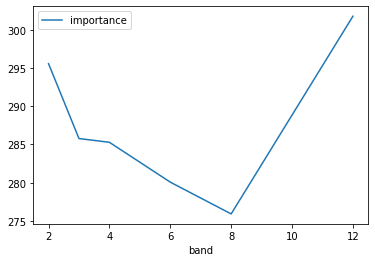

In [13]:
importance_df = pd.DataFrame(vals[1].items(), columns=['band', 'importance'])
importance_df['band'] = importance_df['band'].str.replace('B', '').astype('int')
importance_df.sort_values(by='band', inplace=True)
importance_df.plot(x = 'band', y = 'importance')
plt.show()

### 5. Map Visualizations

 - Define Layers Visualization Parameters

In [14]:
classes_vis_params = {'min': 1,'max': 0}

In [15]:
sentinel2_vis_params = {
    'min': 0.0,
    'max': 10000.0,
    'bands': ['B4','B3','B2']
}

- Interactive Map

In [ ]:
ee_map = geemap.Map(center=(32.600,35.000),
                    zoom = 7.5,
                    add_google_map=False)
 
ee_map.addLayer(israel_ee,{},'Israel')
ee_map.addLayer(sentinel2_image,sentinel2_vis_params,'Sentinel 2')
ee_map.addLayer(smileCart_train_image,classes_vis_params,'SmileCart')
ee_map.addLayer(minimumDistance_train_image,classes_vis_params,'MinimumDistance')
ee_map.addLayer(smileRandomForest_train_image,classes_vis_params,'SmileRandomForest')
ee_map.addLayer(ee_sample_points,{'color':'FF0000'},'ee_training')

ee_map

- Splited Map

In [ ]:
leftLayer = geemap.ee_tile_layer(smileRandomForest_train_image,classes_vis_params,'SmileRandomForest')
rightLayer = geemap.ee_tile_layer(sentinel2_image,sentinel2_vis_params,'Sentinel 2')

split_map = ee_map.split_map(left_layer = leftLayer, right_layer=rightLayer)
split_map

- Linked Map

In [17]:
linked_objects = [sentinel2_image, smileCart_train_image, minimumDistance_train_image, smileRandomForest_train_image]
linked_objects_vis_params = [sentinel2_vis_params,classes_vis_params,classes_vis_params, classes_vis_params]
linked_labels = ['RGB', 'CART', 'Minimum Distance', 'Random Forest']

link_map = geemap.linked_maps(rows=2, cols=2, height="300px",center=[32.600,35.000], zoom=8, 
                              ee_objects=linked_objects,
                              vis_params=linked_objects_vis_params,
                              labels=linked_labels,
                              label_position="topright")
link_map

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

- Export Interactive Map to HTML

In [ ]:
ee_map.to_html(outfile = r"...\ee_map.html",
    title='Buildings Mask Map',
    width='100%',
    height='880px',
    add_layer_control=True)